In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
import spacy
from collections import Counter
import textstat

In [41]:
df = pd.read_csv("combined_suicide_ideation_dataset.csv")
df.head()

,text,label,source
0,Ex Wife Threatening SuicideRecently I left my ...,1,Suicide_Detection.csv
1,Am I weird I don't get affected by compliments...,0,Suicide_Detection.csv
2,Finally 2020 is almost over... So I can never ...,0,Suicide_Detection.csv
3,i need helpjust help me im crying so hard,1,Suicide_Detection.csv
4,"I’m so lostHello, my name is Adam (16) and I’v...",1,Suicide_Detection.csv


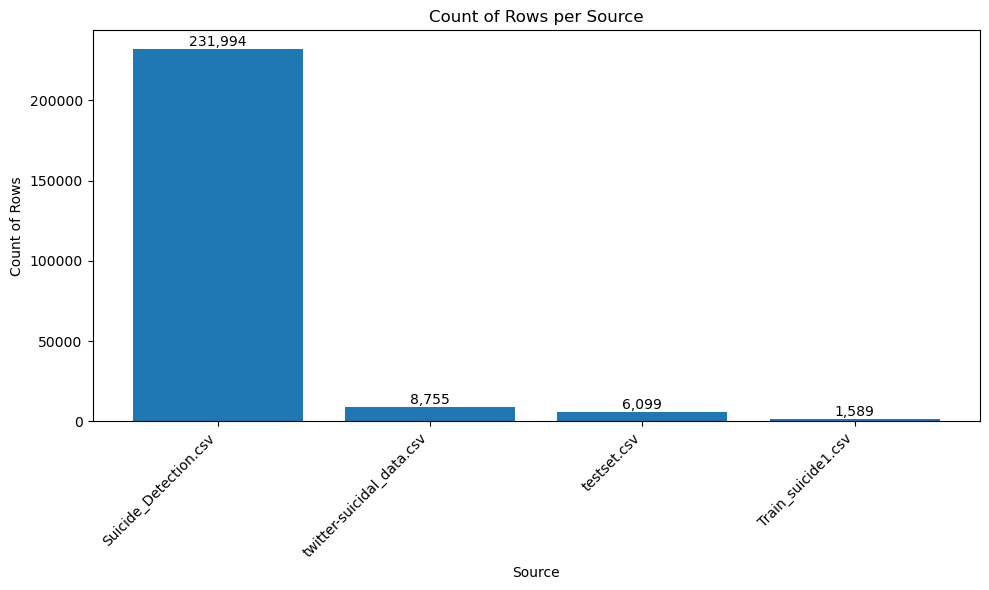

In [42]:
source_counts = df['source'].value_counts()

# Create bar plot with labels
plt.figure(figsize=(10, 6))
bars = plt.bar(source_counts.index, source_counts.values)

# Add labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, height, f'{height:,}', ha='center', va='bottom', fontsize=10)

plt.xlabel("Source")
plt.ylabel("Count of Rows")
plt.title("Count of Rows per Source")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

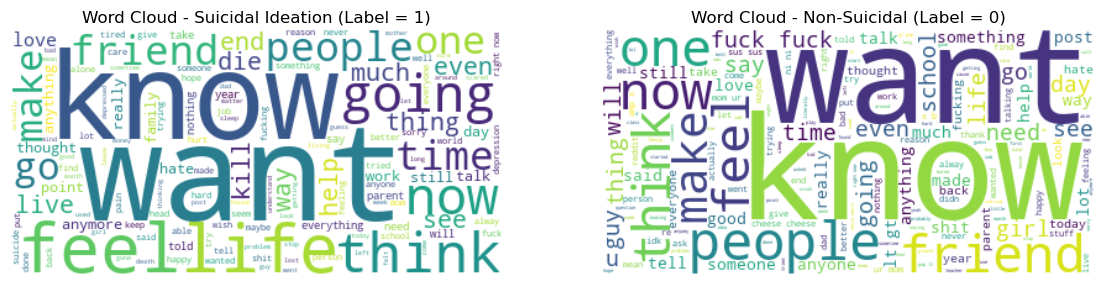

In [43]:
TEXT_COL = "text"
LABEL_COL = "label"

# Function to clean text
def clean_text(text):
    if pd.isna(text):
        return ""
    text = text.lower()  # lowercase
    text = re.sub(r"http\S+|www\S+", "", text)  # remove URLs
    text = re.sub(r"[^a-z\s']", " ", text)  # keep only letters
    text = re.sub(r"\s+", " ", text).strip()  # remove extra spaces
    return text

# Clean text column
df["clean_text"] = df[TEXT_COL].apply(clean_text)

# Separate text by label
text_ideation = " ".join(df[df[LABEL_COL] == 1]["clean_text"].tolist())
text_non_ideation = " ".join(df[df[LABEL_COL] == 0]["clean_text"].tolist())

# Define stopwords
stopwords = set(STOPWORDS)
stopwords.update(["im", "ive", "dont", "cant", "didnt", "doesnt", "wont", "like", "just", "get", "got", "m", "t", "don", "s", "filler", "ve"])

# Generate word clouds
wc_ideation = WordCloud(stopwords=stopwords, background_color="white", max_words=200).generate(text_ideation)
wc_non_ideation = WordCloud(stopwords=stopwords, background_color="white", max_words=200).generate(text_non_ideation)

# Plot the word clouds
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.imshow(wc_ideation, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud - Suicidal Ideation (Label = 1)")

plt.subplot(1, 2, 2)
plt.imshow(wc_non_ideation, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud - Non-Suicidal (Label = 0)")

plt.show()

In [44]:
TEXT_COL = "text"
LABEL_COL = "label"

# Separate text by class
texts_ideation = df[df[LABEL_COL] == 1][TEXT_COL].astype(str).tolist()
texts_non_ideation = df[df[LABEL_COL] == 0][TEXT_COL].astype(str).tolist()

# Create a function to get top TF-IDF words
def get_top_tfidf_words(texts, top_n=20):
    vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
    tfidf_matrix = vectorizer.fit_transform(texts)
    feature_names = vectorizer.get_feature_names_out()
    mean_tfidf = tfidf_matrix.mean(axis=0).A1  # Average TF-IDF score per word
    top_indices = mean_tfidf.argsort()[-top_n:][::-1]
    top_words = [(feature_names[i], mean_tfidf[i]) for i in top_indices]
    return top_words

# Get top words for each class
top_words_ideation = get_top_tfidf_words(texts_ideation, top_n=20)
top_words_non_ideation = get_top_tfidf_words(texts_non_ideation, top_n=20)

# Display results
print("Top TF-IDF Words for Suicidal Ideation (Label = 1):")
for word, score in top_words_ideation:
    print(f"{word}: {score:.4f}")

print("\nTop TF-IDF Words for Non-Suicidal Posts (Label = 0):")
for word, score in top_words_non_ideation:
    print(f"{word}: {score:.4f}")

Top TF-IDF Words for Suicidal Ideation (Label = 1):
just: 0.0591
don: 0.0510
want: 0.0470
like: 0.0412
feel: 0.0388
life: 0.0380
know: 0.0367
ve: 0.0365
people: 0.0278
really: 0.0262
time: 0.0253
going: 0.0246
think: 0.0243
help: 0.0229
anymore: 0.0224
die: 0.0221
kill: 0.0211
fucking: 0.0205
friends: 0.0201
im: 0.0198

Top TF-IDF Words for Non-Suicidal Posts (Label = 0):
just: 0.0333
like: 0.0311
don: 0.0216
want: 0.0197
know: 0.0190
people: 0.0172
day: 0.0149
really: 0.0145
im: 0.0135
feel: 0.0134
time: 0.0131
got: 0.0130
think: 0.0127
good: 0.0125
ve: 0.0125
guys: 0.0118
need: 0.0118
school: 0.0117
help: 0.0112
post: 0.0112


In [45]:
TEXT_COL  = "text"
LABEL_COL = "label"

# Helper: get top n phrases for a subset of rows
def top_phrases_for_subset(texts, ngram_range=(2, 2), top_n=20, stop_words='english', min_df=2):
    vec = CountVectorizer(stop_words=stop_words,ngram_range=ngram_range, min_df=min_df)  # ignore extremely rare phrases
    X = vec.fit_transform(texts)
    counts = X.sum(axis=0).A1
    phrases = vec.get_feature_names_out()
    pairs = list(zip(phrases, counts))
    pairs.sort(key=lambda x: x[1], reverse=True)
    return pairs[:top_n]

# Split by label
texts_pos = df.loc[df[LABEL_COL] == 1, TEXT_COL].astype(str).tolist()
texts_neg = df.loc[df[LABEL_COL] == 0, TEXT_COL].astype(str).tolist()

# Get top bigrams
top_bi_pos = top_phrases_for_subset(texts_pos, ngram_range=(2, 2), top_n=20)
top_bi_neg = top_phrases_for_subset(texts_neg, ngram_range=(2, 2), top_n=20)

print("Top 20 Bigrams — Label=1 (Ideation):")
for phrase, cnt in top_bi_pos:
    print(f"{phrase}: {cnt}")

print("\nTop 20 Bigrams — Label=0 (Non-Ideation):")
for phrase, cnt in top_bi_neg:
    print(f"{phrase}: {cnt}")

# Get top trigrams
top_tri_pos = top_phrases_for_subset(texts_pos, ngram_range=(3, 3), top_n=20)
top_tri_neg = top_phrases_for_subset(texts_neg, ngram_range=(3, 3), top_n=20)

print("\nTop 20 Trigrams — Label=1 (Ideation):")
for phrase, cnt in top_tri_pos:
    print(f"{phrase}: {cnt}")

print("\nTop 20 Trigrams — Label=0 (Non-Ideation):")
for phrase, cnt in top_tri_neg:
    print(f"{phrase}: {cnt}")

Top 20 Bigrams — Label=1 (Ideation):
feel like: 41127
don know: 40642
don want: 32961
just want: 21141
want die: 13405
just don: 9812
don think: 9123
feels like: 6611
high school: 6569
suicidal thoughts: 6361
just feel: 6317
dont know: 6315
ve tried: 6056
don feel: 5501
want kill: 5416
don care: 5329
years ago: 5279
best friend: 5250
want live: 5085
dont want: 4909

Top 20 Bigrams — Label=0 (Non-Ideation):
fuck fuck: 12303
don know: 7130
lt gt: 7106
feel like: 6184
cheese cheese: 5716
sus sus: 5700
ur mom: 5071
mom ur: 5038
ni ni: 3982
don want: 3846
amp x200b: 3785
gt pop: 3739
pop lt: 3738
cum cum: 3475
https www: 2993
just want: 2988
gt lt: 2465
eve eve: 2042
https youtu: 2037
jake paul: 1994

Top 20 Trigrams — Label=1 (Ideation):
just don know: 2904
just feel like: 2555
don want live: 2552
don know anymore: 2455
just want die: 2329
just don want: 2228
don feel like: 2201
don want die: 1986
head head head: 1939
just want end: 1898
don want anymore: 1427
feel like just: 1400
don want

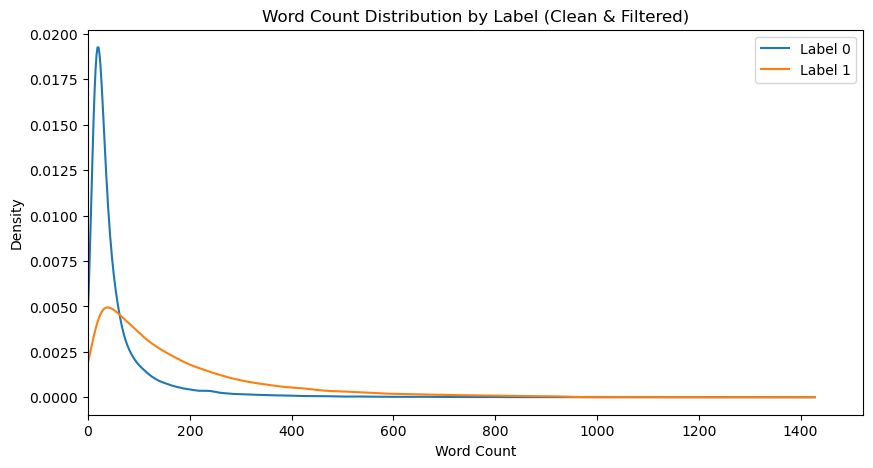

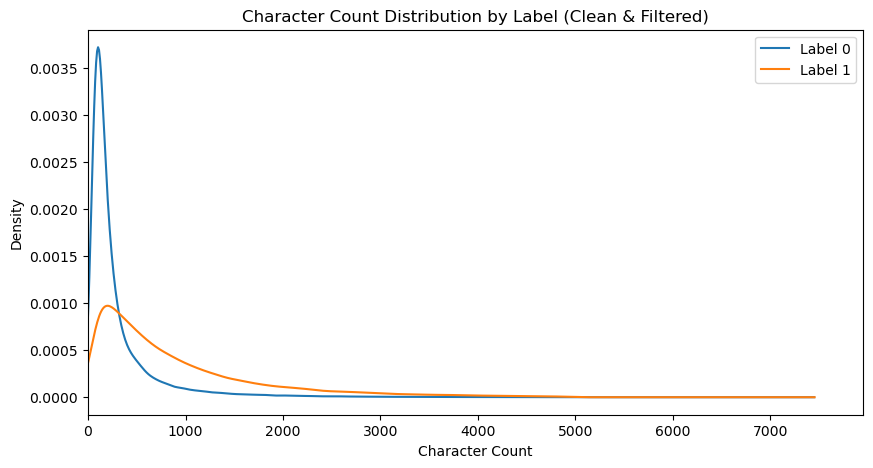

      word_count                                                          \
           count        mean         std  min   25%    50%    75%    max   
label                                                                      
0       123493.0   58.398500   84.302251  1.0  18.0   30.0   60.0  952.0   
1       122333.0  172.906779  168.542502  1.0  54.0  118.0  233.0  952.0   

      char_count                                                             
           count        mean         std  min    25%    50%     75%     max  
label                                                                        
0       123493.0  304.359494  436.314158  1.0   94.0  159.0   316.0  4966.0  
1       122333.0  890.239265  870.760674  3.0  277.0  602.0  1195.0  4970.0  


In [ ]:
df['text'] = df['text'].astype(str)

# Create text length features
df["word_count"] = df["text"].apply(lambda x: len(x.split()))
df["char_count"] = df["text"].apply(lambda x: len(x))

# Remove invalid lengths (<= 0)
df = df[(df["word_count"] > 0) & (df["char_count"] > 0)]

# Remove outliers (keep bottom 99%)
word_count_threshold = df["word_count"].quantile(0.99)
char_count_threshold = df["char_count"].quantile(0.99)

df_filtered = df[(df["word_count"] <= word_count_threshold) & (df["char_count"] <= char_count_threshold)]

# ✅ Word Count Distribution Plot
plt.figure(figsize=(10, 5))
for label in [0, 1]:
    subset = df_filtered[df_filtered['label'] == label]
    subset["word_count"].plot(kind='kde', label=f"Label {label}")
plt.title("Word Count Distribution by Label (Clean & Filtered)")
plt.xlabel("Word Count")
plt.xlim(left=0)  # Force start at 0
plt.legend()
plt.show()

# ✅ Character Count Distribution Plot
plt.figure(figsize=(10, 5))
for label in [0, 1]:
    subset = df_filtered[df_filtered['label'] == label]
    subset["char_count"].plot(kind='kde', label=f"Label {label}")
plt.title("Character Count Distribution by Label (Clean & Filtered)")
plt.xlabel("Character Count")
plt.xlim(left=0)  # Force start at 0
plt.legend()
plt.show()

# Summary statistics
print(df_filtered.groupby('label')[['word_count', 'char_count']].describe())

      flesch_reading_ease                                                 \
                    count       mean         std          min        25%   
label                                                                      
0                123852.0  60.788971  634.356878 -182590.1325  63.317500   
1                124585.0  68.683874   88.638255  -20859.5800  69.236005   

                                    grade_level                             \
             50%        75%     max       count       mean        std  min   
label                                                                        
0      76.369420  86.555000  121.22    123852.0  10.928038  91.826978 -3.4   
1      77.561068  84.240454  121.22    124585.0   9.516141  23.049333 -3.4   

                                                   
            25%       50%       75%           max  
label                                              
0      4.286304  6.718903  9.980769  25482.031667  
1      4.494481  6.1

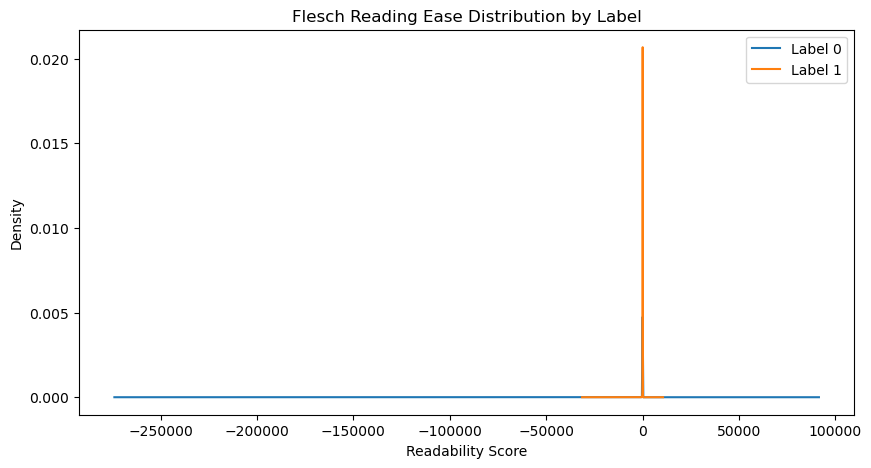

In [56]:
# Compute readability scores
df["flesch_reading_ease"] = df["text"].apply(lambda x: textstat.flesch_reading_ease(x))
df["grade_level"] = df["text"].apply(lambda x: textstat.flesch_kincaid_grade(x))

# Summary statistics
print(df.groupby("label")[["flesch_reading_ease", "grade_level"]].describe())

# Plot readability distribution
plt.figure(figsize=(10, 5))
for label in [0, 1]:
    subset = df[df['label'] == label]
    subset["flesch_reading_ease"].plot(kind='kde', label=f"Label {label}")
plt.title("Flesch Reading Ease Distribution by Label")
plt.xlabel("Readability Score")
plt.legend()
plt.show()

In [ ]:
## If needed

#!python -m spacy download en_core_web_sm

Top POS Tags by Label:
       Non-Suicidal (0)  Suicidal (1)
PRON            1382066       4866462
VERB            1237849       4165873
NOUN            1356738       3436057
PUNCT            853354       2678854
AUX              591314       2239176
ADP              639864       2155986
ADV              535676       1966614
ADJ              496949       1595741
DET              485598       1452598
PART             284261       1237693
CCONJ            324485       1094453
SCONJ            225816        757994
PROPN            518786        246134
NUM              187582        225655
INTJ              64783         76651


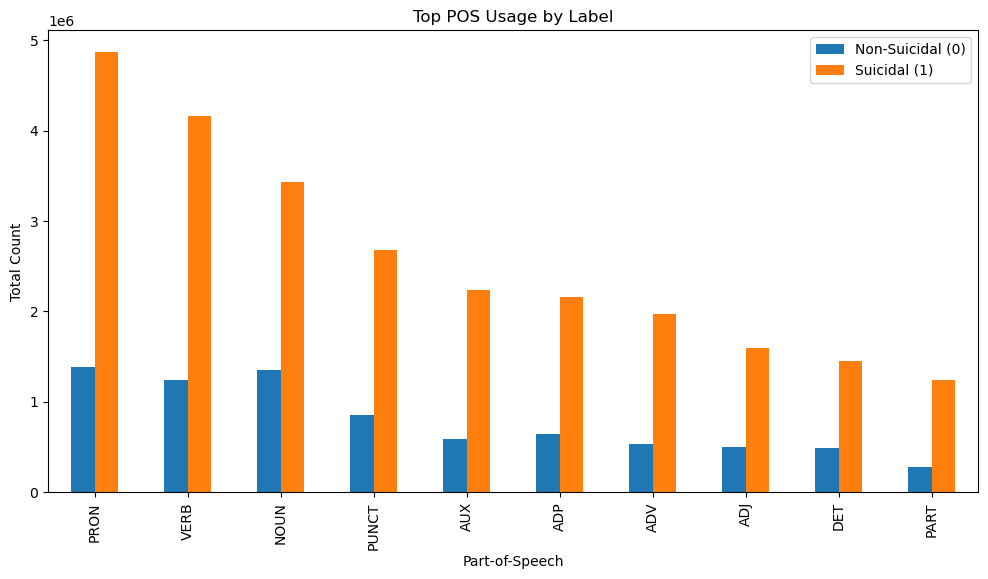

In [53]:
nlp = spacy.load("en_core_web_sm")

def get_pos_counts(text):
    doc = nlp(text)
    return Counter([token.pos_ for token in doc])

df["pos_counts"] = df["text"].apply(get_pos_counts)

# Aggregate POS counts per label
pos_summary = {0: Counter(), 1: Counter()}
for _, row in df.iterrows():
    label = row["label"]
    pos_summary[label].update(row["pos_counts"])

# Convert to DataFrame for comparison
pos_df = pd.DataFrame.from_dict(pos_summary, orient='index').fillna(0).T
pos_df.columns = ["Non-Suicidal (0)", "Suicidal (1)"]
pos_df = pos_df.sort_values(by="Suicidal (1)", ascending=False)

print("Top POS Tags by Label:")
print(pos_df.head(15))

# Plot top POS tags
pos_df.head(10).plot(kind='bar', figsize=(12, 6))
plt.title("Top POS Usage by Label")
plt.ylabel("Total Count")
plt.xlabel("Part-of-Speech")
plt.show()